In [1]:
import psycopg2
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from IPython.display import HTML, display
import datetime
import matplotlib.dates as mdates
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import geopandas as gpd
import shapely
from shapely.geometry import Point
import descartes
import fiona
import os
import seaborn as sns
from matplotlib import rcParams
from matplotlib.collections import QuadMesh
from matplotlib.text import Text
import scipy
import matplotlib.gridspec as gridspec
from scipy import stats
import math
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, PercentFormatter)
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
 

In [2]:
import secretsofcharles as secrets

con = psycopg2.connect(database='bigdata', user=secrets.POSTGRES_USER,
                       password=secrets.POSTGRES_PASSWORD,
                       host=secrets.POSTGRES_HOST, port=secrets.POSTGRES_PORT)

In [3]:
#Colours for plots
to_blue='#175689'
grey = '#7f7e7e'
purple = '#660159'
dark = '#404040'
light = '#d9d9d9'
purple = '#660159'
green = '#0d9f73'
orange = '#d95f02'

In [4]:
#Font properties
leg_font = font_manager.FontProperties(family='Libre Franklin',size=9)
mpl.rc('font',family='Libre Franklin')

In [5]:
plt.rcParams['figure.dpi'] = 450

In [6]:
query = '''

SELECT geom FROM gis.to_core_downtown
WHERE geom is not null

'''

boundary =  gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
boundary  = boundary.to_crs({'init' :'epsg:3857'})

for index, row in boundary.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    boundary.loc[index, 'geom'] = rotated
    
query = '''

SELECT geom FROM gis.neighbourhood
WHERE area_s_cd::integer = 77

'''

spadina =  gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
spadina  = spadina.to_crs({'init' :'epsg:3857'})

for index, row in spadina.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    spadina.at[index, 'geom'] = rotated

In [7]:
query = '''

SELECT * FROM gis.subway_to

'''
ttc = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
ttc = ttc.to_crs({'init' :'epsg:3857'})

for index, row in ttc.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    ttc.at[index, 'geom'] = rotated

In [8]:
query = '''

SELECT 
       geom
FROM tts.zones_tts06
WHERE gta06 = 81

;

'''

island = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
island = island.to_crs({'init' :'epsg:3857'})

for index, row in island.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    island.at[index, 'geom'] = rotated

In [9]:
query = '''


SELECT the_geom as geom FROM gis.community_council_2018
WHERE ogc_fid = 3
'''


district = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
district = district.to_crs({'init' :'epsg:3857'})

for index, row in district.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    district.at[index, 'geom'] = rotated

In [10]:
query = '''

WITH sums AS (
    SELECT period_uid,
           hr,
           extract(month from pickup_datetime) as mon,
           extract(year from pickup_datetime) as yr,
           extract(week from pickup_datetime) as wk,
           pickup_neighbourhood, 
           sum(count) as count  
    FROM ptc.trip_data_agg_neighbourhood
    LEFT JOIN ptc.period_lookup_simple ON hr=period_hr and extract(dow from pickup_datetime)=period_dow
    WHERE period_uid IN (1,4)
    GROUP BY period_uid, hr, pickup_datetime, pickup_neighbourhood
    ORDER BY  period_uid
), peak AS  (

    SELECT period_name, avg(count) as count, pickup_neighbourhood 
    from sums
    LEFT JOIN ptc.periods_simple USING (period_uid)
    WHERE (yr = 2018 AND mon = 9) AND period_uid=1
    GROUP BY period_name, pickup_neighbourhood
    ORDER BY count
), fri_sat AS  (

    SELECT period_name, avg(count) as count, pickup_neighbourhood 
    FROM sums
    LEFT JOIN ptc.periods_simple USING (period_uid)
    WHERE (yr = 2018 AND mon = 9) AND period_uid=4
    GROUP BY period_name, pickup_neighbourhood
    ORDER BY count

)

SELECT pickup_neighbourhood, a.period_name, a.count/(a.count+b.count) AS ratio_peak, a.count as peak, b.count as fri_sat, geom
FROM peak a
LEFT JOIN fri_sat b USING (pickup_neighbourhood)
LEFT JOIN gis.neighbourhood ON area_s_cd::integer=pickup_neighbourhood
ORDER BY pickup_neighbourhood DESC

'''

neigh_period_sept18 = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
neigh_period_sept18 = neigh_period_sept18.to_crs({'init' :'epsg:3857'})

for index, row in neigh_period_sept18.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    neigh_period_sept18.at[index, 'geom'] = rotated

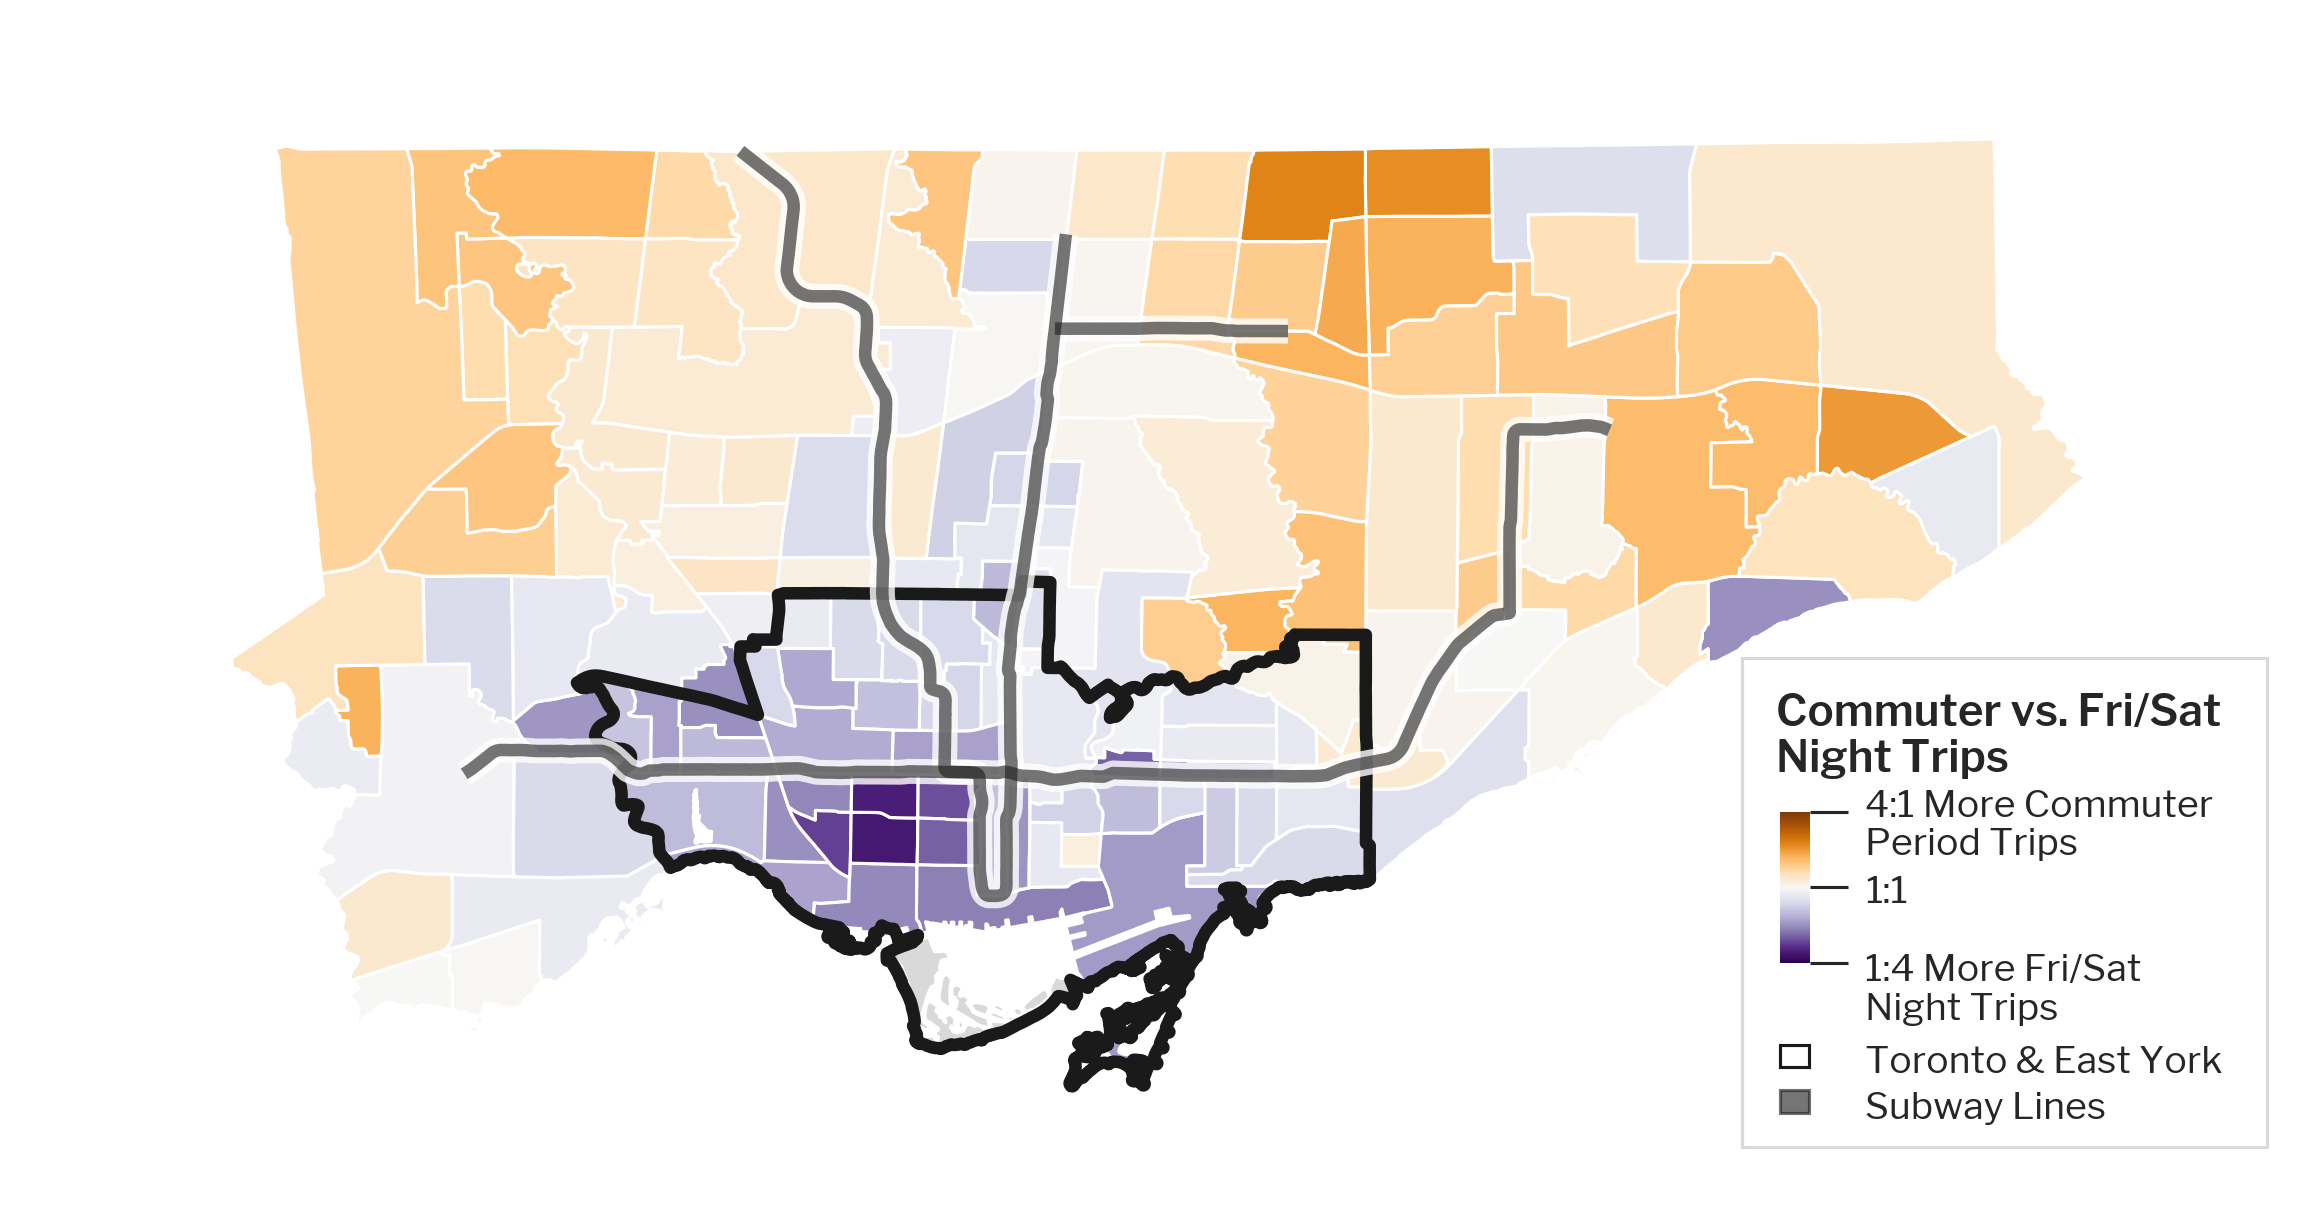

In [27]:

fig, ax = plt.subplots()
fig.set_size_inches(6.69,3.345)
 
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()
 
mpd = neigh_period_sept18.plot(column='ratio_peak', linewidth =0.5, ax=ax, vmin=0.2, vmax=0.8,  cmap = 'PuOr_r')
line = ttc.plot( ax=ax, label='test', linewidth =4, color = 'w', alpha =0.8) # ttc subway layer
line = ttc.plot( ax=ax, label='test', linewidth =2, color = 'k', alpha =0.6) # ttc subway layer
to_island = island.plot( ax=ax, label='test', linewidth =0.5, color = light, edgecolor='w')
cc = district.plot( ax=ax, label='test', facecolor='none', linewidth =2, edgecolor='k')

props = dict(boxstyle='round', facecolor='w', alpha=0)
plt.text(0.775, 0.354, 'Commuter vs. Fri/Sat\nNight Trips', transform=ax.transAxes, wrap = True, fontsize=7, fontname = 'Libre Franklin SemiBold',
        verticalalignment='bottom', bbox=props, fontweight = 'bold') # Adding the Legend Title
 
plt.text(0.815, 0.282, '4:1 More Commuter\nPeriod Trips', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props) # Manually defining the unit in the legend

plt.text(0.815, 0.24, '1:1', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

plt.text(0.815, 0.137, '1:4 More Fri/Sat\nNight Trips', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)
 
cax = fig.add_axes([0.718, 0.27, 0.01, 0.10]) # Size of colorbar
 
rect = patches.Rectangle((0.76, 0.03),0.235,0.43,linewidth=0.5, transform=ax.transAxes, edgecolor=light,
                   facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((0.777, 0.06),0.013,0.02,linewidth=0.5, transform=ax.transAxes, edgecolor='k',
                       alpha = 0.6, facecolor='k')
ax.add_patch(rect)
plt.text(0.815, 0.05, 'Subway Lines', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

rect = patches.Rectangle((0.777, 0.1),0.013,0.02,linewidth=0.5, transform=ax.transAxes, edgecolor='k',
                       facecolor='none')
ax.add_patch(rect)
plt.text(0.815, 0.09, 'Toronto & East York', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

ax.margins(0.1)

sm = plt.cm.ScalarMappable(cmap='PuOr_r', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.outline.set_linewidth(0)
tick_locator = ticker.MaxNLocator(nbins=2)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.ax.set_yticklabels([])

cbr.ax.yaxis.set_tick_params(width=0.5)
cbr.ax.tick_params(labelsize=6)  # Formatting for Colorbar Text
for l in cbr.ax.yaxis.get_ticklabels():
    l.set_family("Libre Franklin")

plt.savefig('/mnt/c/Users/czhu5/Documents/Ubuntu/GitHub/bdit_vfh/paper/source/figures/trb_commuteratio.pdf',
            bbox_inches='tight')

In [31]:
tey

,period_name,period_uid,count,hr,dow,swatch
0,None,NaN,2843.00,0,1.0,#999999
1,None,NaN,2024.75,1,1.0,#999999
2,None,NaN,1780.25,2,1.0,#999999
3,Weekday Overnight,10.0,1107.50,3,1.0,#BF399E
4,Weekday Overnight,10.0,838.75,4,1.0,#BF399E
5,Weekday Overnight,10.0,1068.75,5,1.0,#BF399E
6,Weekday Overnight,10.0,1724.50,6,1.0,#BF399E
7,Weekday Commuter,1.0,2725.00,7,1.0,#E8743B
8,Weekday Commuter,1.0,3573.00,8,1.0,#E8743B
9,Weekday Commuter,1.0,4235.50,9,1.0,#E8743B


In [12]:
query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
AND pickup_ward2018 IN (1,2,3,7,5)
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
ey = pandasql.read_sql(query,con)

query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
AND pickup_ward2018 IN (6,8,18,17,15,16)
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
ny = pandasql.read_sql(query,con)

query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
AND pickup_ward2018 IN (4,9,10,11,12,13,14,19)
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
tey = pandasql.read_sql(query,con)

query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
AND pickup_ward2018 IN (20,21,22,23,24,25)
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
sb = pandasql.read_sql(query,con)

query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
AND pickup_ward2018 NOT IN (4,9,10,11,12,13,14,19)
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
suburb = pandasql.read_sql(query,con)


In [13]:
sns.set(font_scale=1.5)


In [14]:
sns.set(font_scale=1.5)

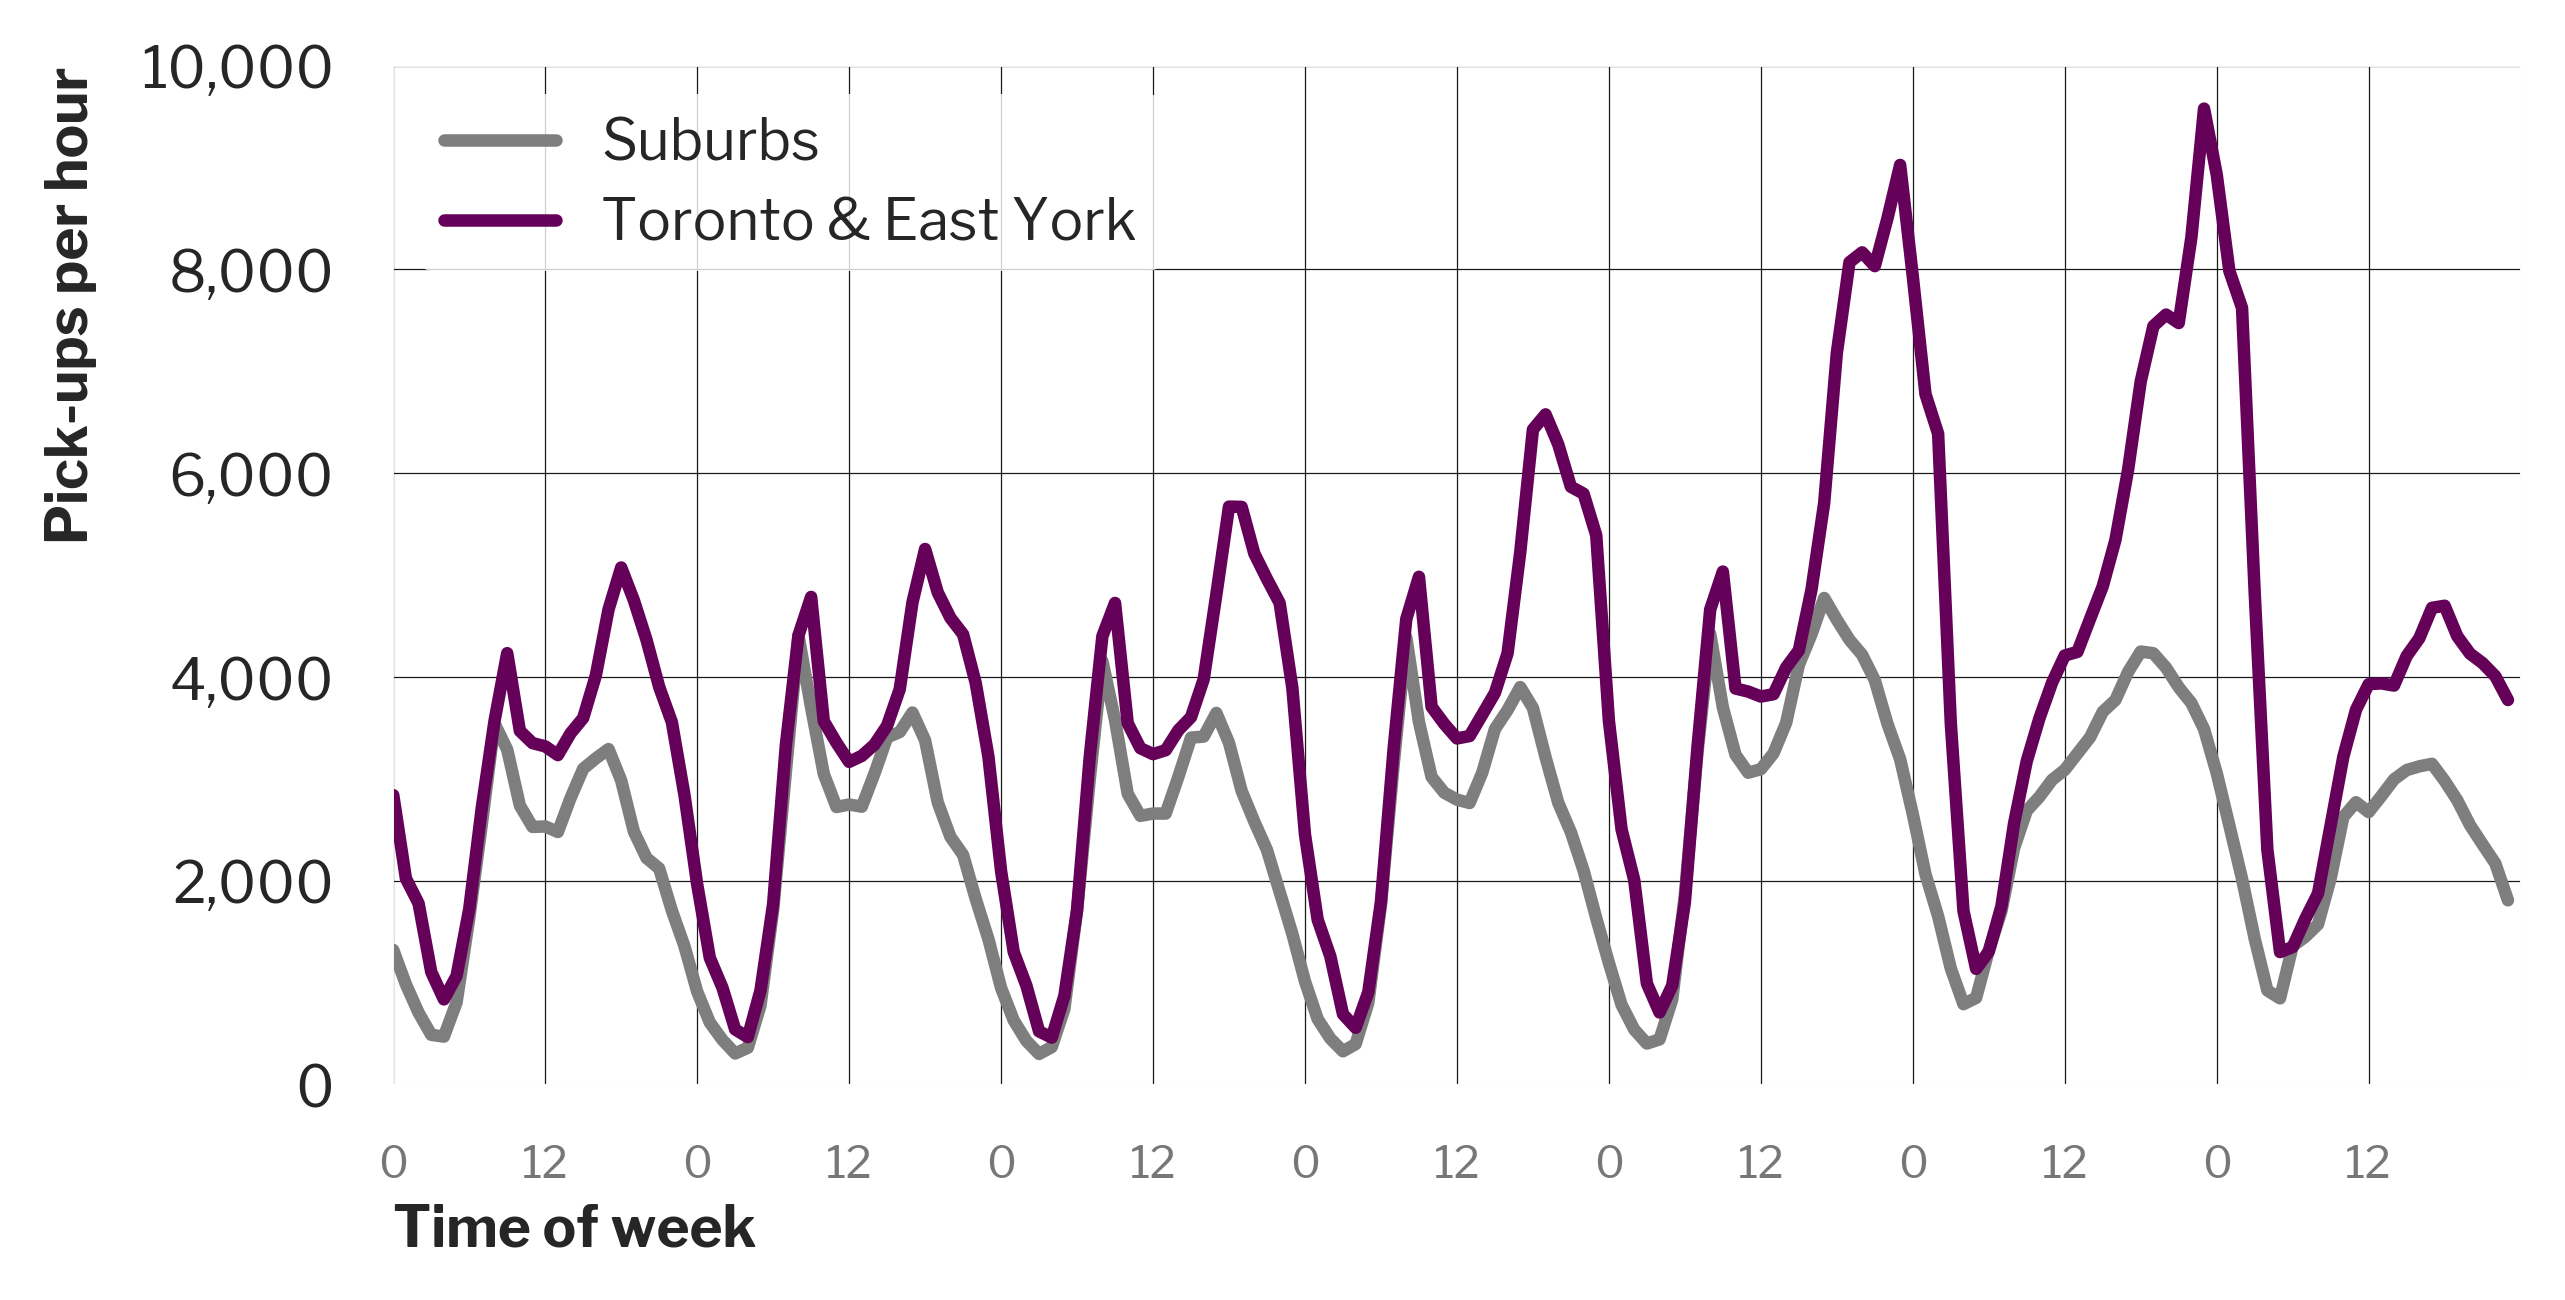

In [20]:


leg_font = font_manager.FontProperties(family='Libre Franklin',size=9)


fig, (ax4) =plt.subplots(figsize=(6.1, 3))


plt.grid()
ax4.set_facecolor('xkcd:white')
ax4.set_ylim([0,10000])
ax4.grid(color='k', linestyle='-', linewidth=0.2)
plt.ylabel('Pick-ups per hour', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='right', y=1, labelpad=7, fontweight = 'bold')
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.yticks(range(0,11000,2000), fontname = 'Libre Franklin', fontsize=9)

plt.xlabel('Time of week', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='left', x=0, labelpad=3, fontweight = 'bold')
ax4.set_xlim([0,167])
ax4.tick_params(axis='x', which='minor', colors = 'k', labelsize=9, pad =14)
ax4.xaxis.set_minor_locator(ticker.FixedLocator(list(range(12,180,24))))
ax4.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))
ax4.set_xticklabels(7 * ['0','12'], fontname = 'Libre Franklin', fontsize = 7, color = '#777777')
ax4.set_xticks(range(0,180,12))

p1 = ax4.plot(tey.index.values, suburb['count'], linewidth = 2, color = grey)
p2 = ax4.plot(tey.index.values, tey['count'], linewidth = 2, color = purple)

leg = ax4.legend((p1[0], p2[0]), ('Suburbs', 'Toronto & East York'), loc=2, frameon=True, prop=leg_font)
frame = leg.get_frame()
frame.set_facecolor('xkcd:white')
frame.set_linewidth(0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.savefig('C:/Users/czhu5/Documents/Ubuntu/GitHub/bdit_vfh/paper/source/figures/trb_tow.pdf',
            bbox_inches='tight')
plt.show()

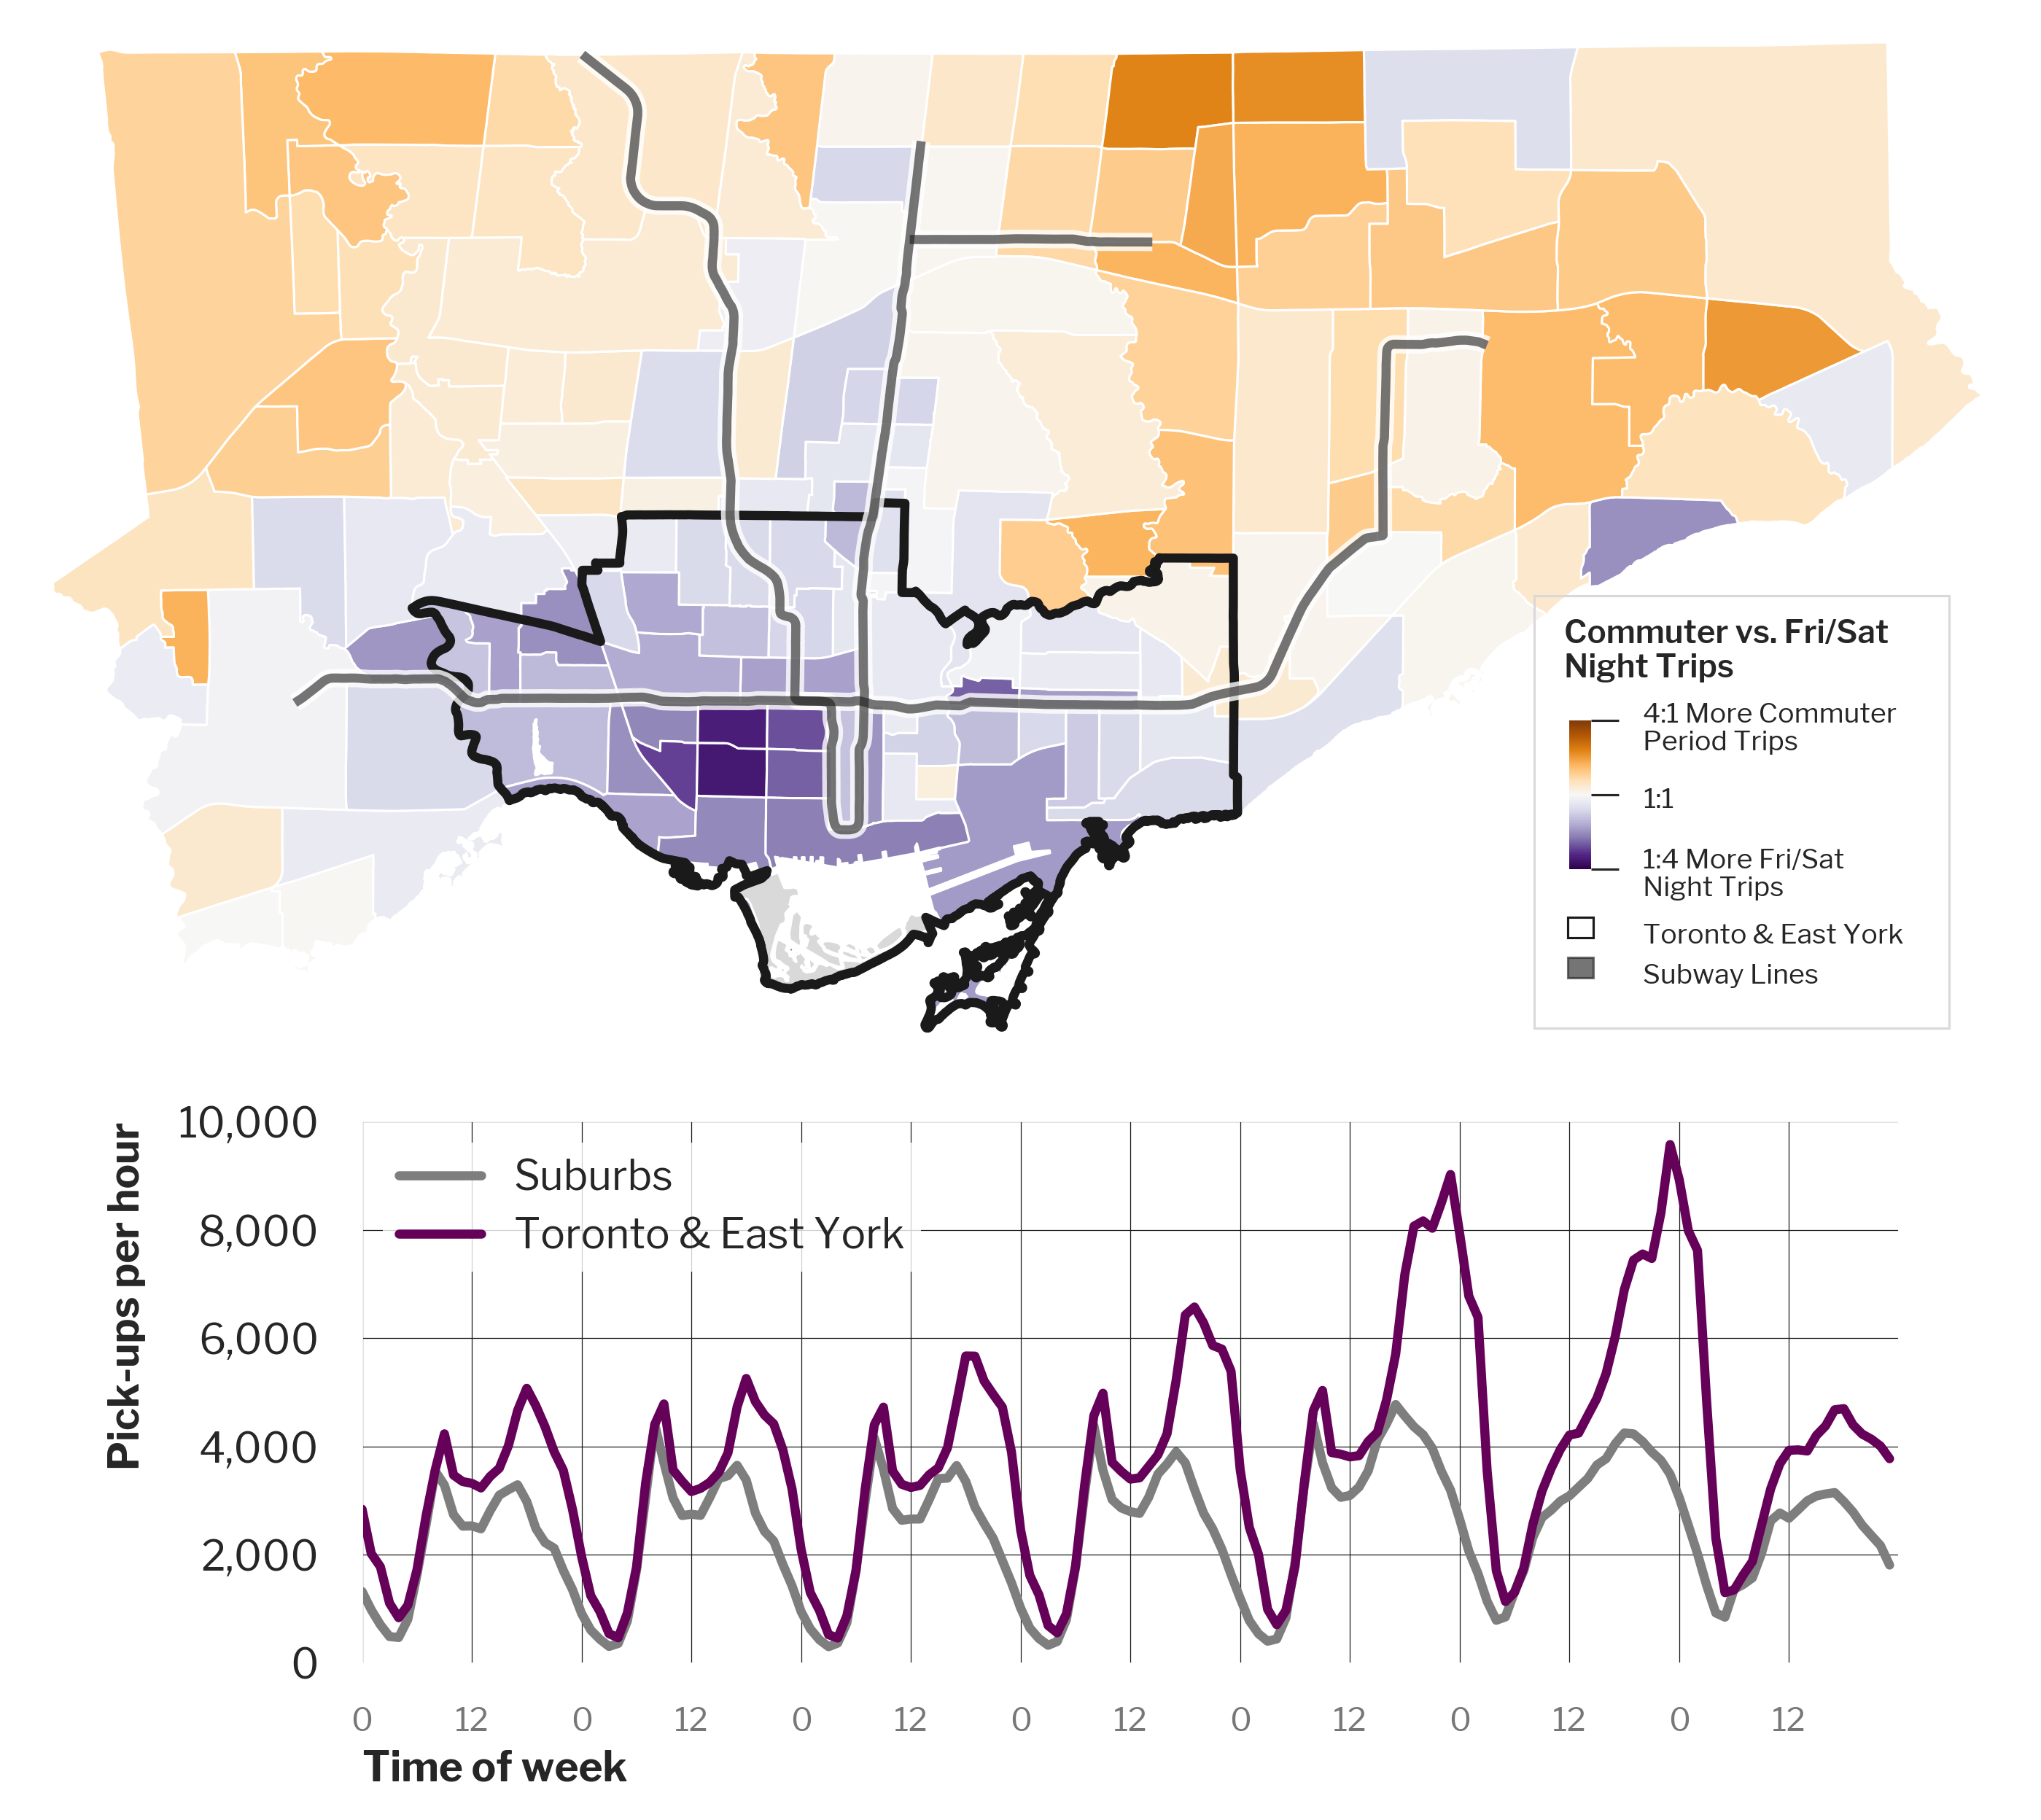

In [150]:
fig = plt.figure(figsize=(6.69, 5.5))

ax1 = fig.add_axes([0.05, 0.35, 0.9, 0.75])
ax2 = fig.add_axes([0.2, 0.1, 0.7, 0.3])
 
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_axis_off()
 
mpd = neigh_period_sept18.plot(column='ratio_peak', linewidth =0.5, ax=ax1, vmin=0.2, vmax=0.8,  cmap = 'PuOr_r')
line = ttc.plot( ax=ax1, label='test', linewidth =4, color = 'w', alpha =0.8) # ttc subway layer
line = ttc.plot( ax=ax1, label='test', linewidth =2, color = 'k', alpha =0.6) # ttc subway layer
to_island = island.plot( ax=ax1, label='test', linewidth =0.5, color = light, edgecolor='w')
cc = district.plot( ax=ax1, label='test', facecolor='none', linewidth =2, edgecolor='k')

props = dict(boxstyle='round', facecolor='w', alpha=0)
plt.text(0.775, 0.354, 'Commuter vs. Fri/Sat\nNight Trips', transform=ax1.transAxes, wrap = True, fontsize=7, fontname = 'Libre Franklin SemiBold',
        verticalalignment='bottom', bbox=props, fontweight = 'bold') # Adding the Legend Title
 
plt.text(0.815, 0.282, '4:1 More Commuter\nPeriod Trips', transform=ax1.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props) # Manually defining the unit in the legend

plt.text(0.815, 0.225, '1:1', transform=ax1.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

plt.text(0.815, 0.137, '1:4 More Fri/Sat\nNight Trips', transform=ax1.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)
 
cax = fig.add_axes([0.75, 0.54, 0.01, 0.0825]) # Size of colorbar
 
rect = patches.Rectangle((0.76, 0.01),0.21,0.43,linewidth=0.5, transform=ax1.transAxes, edgecolor=light,
                   facecolor='none')
ax1.add_patch(rect)

rect = patches.Rectangle((0.777, 0.06),0.013,0.02,linewidth=0.5, transform=ax1.transAxes, edgecolor='k',
                       alpha = 0.6, facecolor='k')
ax1.add_patch(rect)
plt.text(0.815, 0.05, 'Subway Lines', transform=ax1.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

rect = patches.Rectangle((0.777, 0.1),0.013,0.02,linewidth=0.5, transform=ax1.transAxes, edgecolor='k',
                       facecolor='none')
ax1.add_patch(rect)
plt.text(0.815, 0.09, 'Toronto & East York', transform=ax1.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
        verticalalignment='bottom', ha = 'left', bbox=props)

sm = plt.cm.ScalarMappable(cmap='PuOr_r', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.outline.set_linewidth(0)
tick_locator = ticker.MaxNLocator(nbins=2)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.ax.set_yticklabels([])

cbr.ax.yaxis.set_tick_params(width=0.5)
cbr.ax.tick_params(labelsize=6)  # Formatting for Colorbar Text
for l in cbr.ax.yaxis.get_ticklabels():
    l.set_family("Libre Franklin")

ax2.set_facecolor('xkcd:white')
ax2.set_ylim([0,10000])
ax2.grid(color='k', linestyle='-', linewidth=0.2)
ax2.set_ylabel('Pick-ups per hour', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='right', y=1, labelpad=7, fontweight = 'bold')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax2.set_xlabel('Time of week', fontname = 'Libre Franklin', fontsize=9, horizontalalignment='left', x=0, labelpad=3, fontweight = 'bold')
ax2.set_xlim([0, 167])
ax2.tick_params(axis='x', which='minor', colors = 'k', labelsize=9, pad =14)
ax2.xaxis.set_minor_locator(ticker.FixedLocator(list(range(12,180,24))))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))
ax2.set_xticks(range(0,180,12))
ax2.set_xticklabels(7 * ['0','12'], fontname = 'Libre Franklin', fontsize=7, color='#777777')
ax2.set_yticklabels(range(0,11000,2000), fontname = 'Libre Franklin', fontsize=9)
ax2.set_yticks(range(0,11000,2000))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

p1 = ax2.plot(tey.index.values, suburb['count'], linewidth = 2, color = grey)
p2 = ax2.plot(tey.index.values, tey['count'], linewidth = 2, color = purple)

leg = ax2.legend((p1[0], p2[0]), ('Suburbs', 'Toronto & East York'), loc=2, frameon=True, prop=leg_font)
frame = leg.get_frame()
frame.set_facecolor('xkcd:white')
frame.set_linewidth(0)

ax1.margins(0.01)
plt.savefig('/mnt/c/Users/czhu5/Documents/Ubuntu/GitHub/bdit_vfh/paper/source/figures/trb_commute_tow.pdf',
            bbox_inches='tight')